# Mixture of Individualized Treatment Effects
Justification for the appraoch is available [here](https://fcgrolleau.github.io/clusterITE/Mixture_of_ITEs.pdf).

### Generate Data

In [48]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

In [49]:
# Sample a 2x2 orthonormal matrix
orth_mat = ortho_group.rvs(dim=2)

# Create a 2x2 positive semi-definite matrix with eigenvalues 2 and 3
sigma_mat = orth_mat @ np.diag([2, 3]) @ orth_mat.T

# Sample 1000 points from a 2D Gaussian
X = np.random.multivariate_normal(mean=[0, 0], cov=sigma_mat, size=1000)

In [50]:
# Create parameters for the probability of belonging to each of the 3 clusters
cl1_param = np.array([-9, -8])
cl2_param = np.array([9, 8])
cl3_param = np.array([-4, 2])

cl_param = np.array([cl1_param, cl2_param, cl3_param])

In [51]:
# Create these probabilities for each point
def softmax(X, cl_param, k):
    return np.exp(X @ cl_param[k]) / np.sum([np.exp(X @ cl_param[i]) for i in range(cl_param.shape[0])], axis=0)

def all_softmax(X, cl_param):
    return np.array([softmax(X, cl_param, k) for k in range(cl_param.shape[0])]).T

cluster_prob = all_softmax(X, cl_param)
cluster_prob

array([[1.00000000e+00, 1.66653231e-19, 3.89151215e-12],
       [4.68944788e-02, 2.67813263e-01, 6.85292258e-01],
       [9.99842671e-01, 8.76919609e-13, 1.57329369e-04],
       ...,
       [1.99871846e-11, 9.99955727e-01, 4.42727380e-05],
       [7.13039797e-01, 8.43981202e-02, 2.02562082e-01],
       [9.99999979e-01, 5.45103460e-13, 2.10084591e-08]])

NB: we picked parameters so that the real probabilities above are close to 0 or 1. This is merely for simplicity of the illustration, and could straightforwardly be complexified.

In [52]:
# For the real clusters, sample one hot encoded random vectors from a multinomial distribution
cluster_real_oh = np.array([np.random.multinomial(n=1, pvals=cluster_prob[i]) for i in range(cluster_prob.shape[0])])
cluster_real_oh

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [53]:
# Convert one hot encoding to categorical
cluster_real_cat = cluster_real_oh.argmax(axis=1)

# Number of points in each cluster
np.unique(cluster_real_cat, return_counts=True)

(array([0, 1, 2]), array([418, 448, 134]))

In [54]:
# Create parameters for each of the 3 experts
ex1_param = np.array([-.1, .8])
ex2_param = np.array([-.3, .5])
ex3_param = np.array([-.6, .3])

# Store the parameters in a 3x2 matrix
ex_param = np.array([ex1_param, ex2_param, ex3_param])

In [55]:
# Create all predictions for the 3 experts for all points
# To mimic individualized treatment effects (ITEs), bound the predictions between -1 and +1 like so
ex_preds = 2 * np.array([1 / (1 + np.exp(-X @  ex_param[ex])) for ex in range(ex_param.shape[0])]) - 1 

ex_preds.shape, (np.min(ex_preds), np.max(ex_preds))

((3, 1000), (-0.9635830689090656, 0.960187752247373))

In [56]:
# Pick as real ITE the prediction from the corresponding cluster
# by applying the one-hot encoding mask like so
y = np.sum(ex_preds.T * cluster_real_oh, axis=1)
y.shape, (np.min(y), np.max(y))

((1000,), (-0.9635830689090656, 0.9508531937661922))

### Describe our simulated dataset

Plot the marginal distribution of the Individual Treatment Effects (ITE)

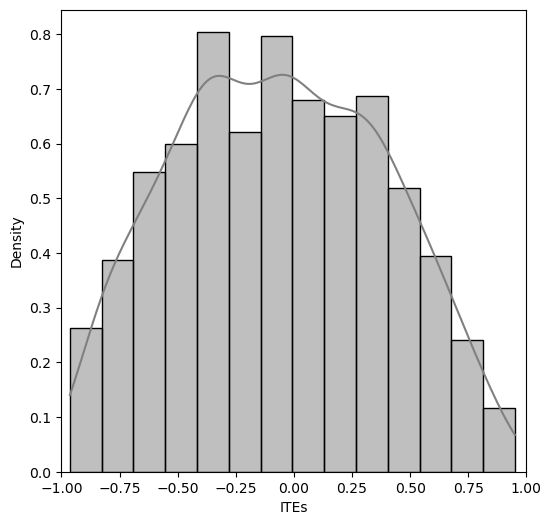

In [57]:
import seaborn as sns
plt.figure(figsize=(6, 6))
ax = sns.histplot(y, color='Gray', kde=True, stat = 'density')
ax.set_xlim(-1, 1)
ax.set_xlabel('ITEs');

Plot the distribution of the Individual Treatment Effects conditional on the cluster assignment

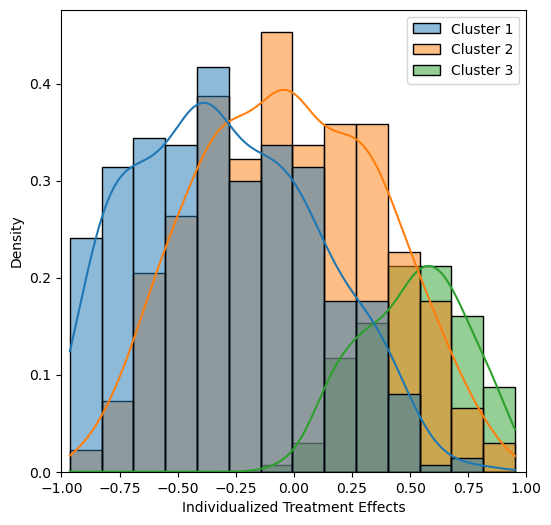

In [58]:
cluster_name = ['Cluster ' + str(cluster_real_cat[i] + 1) for i in range(cluster_real_cat.shape[0])]
sim_dat = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'cluster': cluster_real_cat, 'cluster_name': cluster_name, 'y':y})
hue_order = ['Cluster 1', 'Cluster 2', 'Cluster 3']

plt.figure(figsize=(6, 6))
ax = sns.histplot(data=sim_dat, x=y, hue=cluster_name, hue_order=hue_order, stat='density', kde=True)
ax.set_xlim(-1, 1)
ax.set_xlabel('Individualized Treatment Effects');

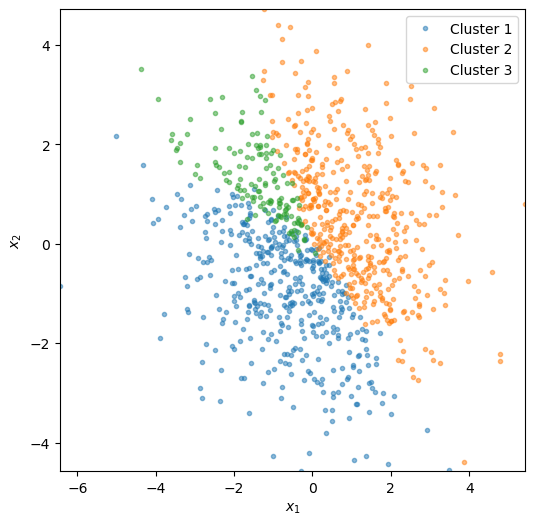

In [59]:
# Keep the same color for the clusters
colors = sns.color_palette()

# Plot the points
plt.figure(figsize=(6, 6))
plt.plot(X[cluster_real_cat==0, 0], X[cluster_real_cat==0, 1], '.', color=colors[0], alpha=.5, label='Cluster 1')
plt.plot(X[cluster_real_cat==1, 0], X[cluster_real_cat==1, 1], '.', color=colors[1], alpha=.5, label='Cluster 2')
plt.plot(X[cluster_real_cat==2, 0], X[cluster_real_cat==2, 1], '.', color=colors[2], alpha=.5, label='Cluster 3')

# Add x-label and y-label
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')

# Set x-limits and y-limits
x1_min  = np.min(X[:,0]) ; x1_max  = np.max(X[:,0])
x2_min  = np.min(X[:,1]) ; x2_max  = np.max(X[:,1])

plt.xlim([x1_min, x1_max]); plt.ylim([x2_min, x2_max])

# Add a legend
plt.legend()

# Good to go!
plt.show();

In [60]:
def plot_clusters(X, y, clusters, title=None):
    # Make three plots by columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3.5))

    # Plot the points
    im1 = ax1.scatter(X[clusters==0, 0], X[clusters==0, 1], c=y[clusters==0], cmap='seismic', marker = '.', alpha=.5, label='Cluster 1', vmin=-1, vmax=1)
    im2 = ax2.scatter(X[clusters==1, 0], X[clusters==1, 1], c=y[clusters==1], cmap='seismic', marker = '.', alpha=.5, label='Cluster 2', vmin=-1, vmax=1)
    im3 = ax3.scatter(X[clusters==2, 0], X[clusters==2, 1], c=y[clusters==2], cmap='seismic', marker = '.', alpha=.5, label='Cluster 3', vmin=-1, vmax=1)

    ax1.set_xlim([x1_min, x1_max])
    ax2.set_xlim([x1_min, x1_max])
    ax3.set_xlim([x1_min, x1_max])

    ax1.set_ylim([x2_min, x2_max])
    ax2.set_ylim([x2_min, x2_max])
    ax3.set_ylim([x2_min, x2_max])

    # count unique values in each cluster
    cluster_count = np.unique(clusters, return_counts=True)[1]

    ax1.set_title('Cluster 1\nn=' + str(cluster_count[0]) + f' of {len(X)}')
    ax2.set_title('Cluster 2\nn=' + str(cluster_count[1]) + f' of {len(X)}')
    ax3.set_title('Cluster 3\nn=' + str(cluster_count[2])+ f' of {len(X)}')

    # give x-label and y-label
    ax1.set_xlabel('$x_1$'); ax1.set_ylabel('$x_2$')
    ax2.set_xlabel('$x_1$')
    ax3.set_xlabel('$x_1$')

    cb = fig.colorbar(im3, ax=(ax1, ax2, ax3), orientation='vertical')
    cb.set_label('Individualized Treatment Effect')

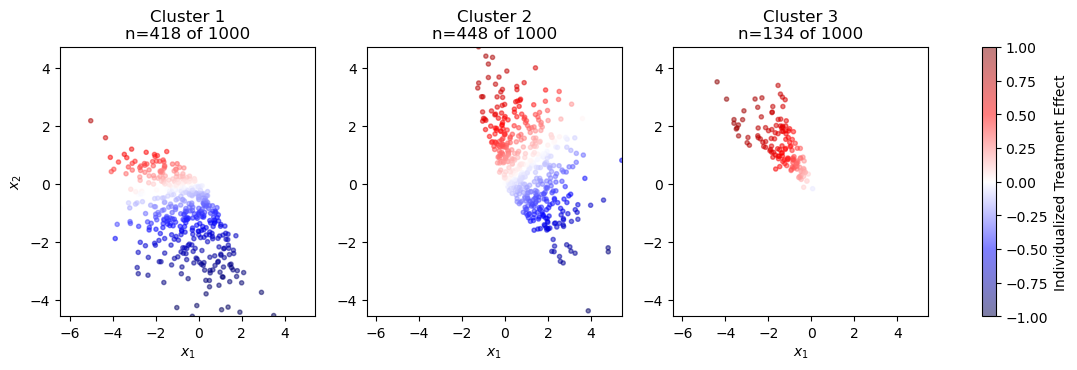

In [61]:
plot_clusters(X, y, cluster_real_cat)

### Mixture of experts and the EM algorithm

In [62]:
# For the experts we can use random forests
from sklearn.ensemble import RandomForestRegressor

# For simplicity in this parametric simulation, we will use linear regression
from sklearn.linear_model import LinearRegression

In [63]:
# For the gating network, deep learning libraries are more convenient
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping

In [64]:
# Choose the number of clusters
K = 3

In [65]:
# Instantiate our expert models and store them in a dictionary 
experts = {f"ex_mod_{k}": LinearRegression() for k in range(K)}

# If we wished to use random forrests for each expert, we could do it like so
#experts = {f"ex_mod_{k}": RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10) for k in range(K)}

In [66]:
# Instantiate our gating network
def tf_model(n_clusters):
    model = Sequential()
    model.add(Dense(n_clusters, use_bias=True, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

gating_net = tf_model(K)

# Create a callback to stop training when the loss stops decreasing
Callback = EarlyStopping(monitor='loss', patience=4)

The algorithm is as follows:

In [67]:
# Initialize the cluster probabilities
G = np.ones((len(X), K)) / K

# Initialize the individual predictions from the experts
U = np.random.normal(loc=0, scale=10, size=(len(X), K))

# Broadcast our targets in a matrix for ease of use later
Y = np.repeat(np.array(y)[:, np.newaxis], K, axis=1)

In [68]:
# Iterate over the EM algorithm
maxiter = 100; epsi = 1e-6; verbose = False
for it in range(maxiter):
    
    ### E step ###
    # Compute individual contributions to each expert’s likelihood as
    L = stats.norm.pdf(Y, loc=U, scale=1)
    
    # Compute the posterior cluster probabilities as
    H = (G * L) / np.sum(G * L, axis=1)[:, np.newaxis]

    ### M step ###
    ## 1. Experts substeps
    # Fit all expert models separately
    for k, mod in enumerate(experts.values()):
        mod.fit(X, y, sample_weight=H[:, k])

    # Update the predictions from the expert networks as
    U = []
    for k, mod in enumerate(experts.values()):
        U.append(mod.predict(X))
    U = np.array(U).T
   
    ## 2. Gating network substep
    # Fit the gating network jointly
    gating_net.fit(X, H, epochs=50, batch_size=len(X), verbose=0, callbacks=[Callback])
    
    # Update the cluster probabilities as
    G_old = G
    G = gating_net.predict(X, verbose=0)
    
    # Check for convergence on the frobenius norm of the difference
    if np.linalg.norm(G - G_old, ord='fro') / (len(X) * K) < epsi: 
        print(f'\nConverged at iteration {it}')
        break
    
    if verbose and it % 10 == 0:
        print(f'iteration {it+1} ; \
              Accuracy on H {(np.argmax(G, axis=1) == np.argmax(H, axis=1)).mean()*100:.2f}% \n', \
              end='\r')
        print(G, end='\r')


Converged at iteration 1


## Results

Here are the three clusters identified by our mixture of experts

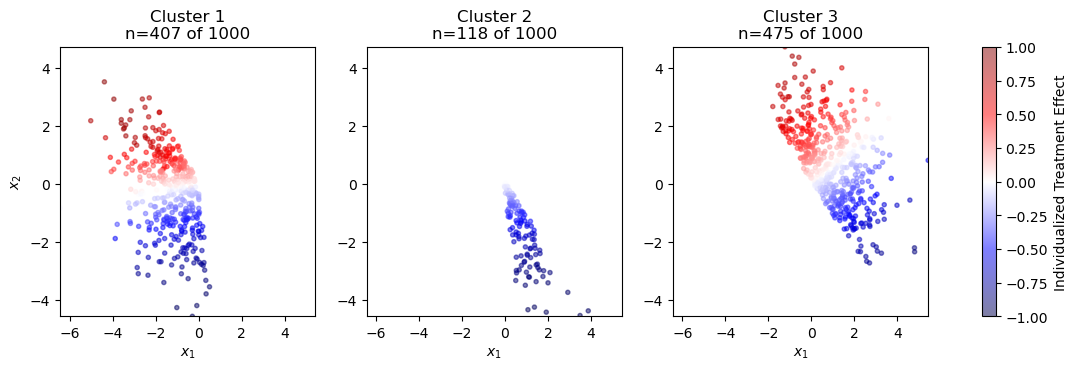

In [69]:
plot_clusters(X, y, np.argmax(G, axis=1))

Versus the true clusters we saw earlier

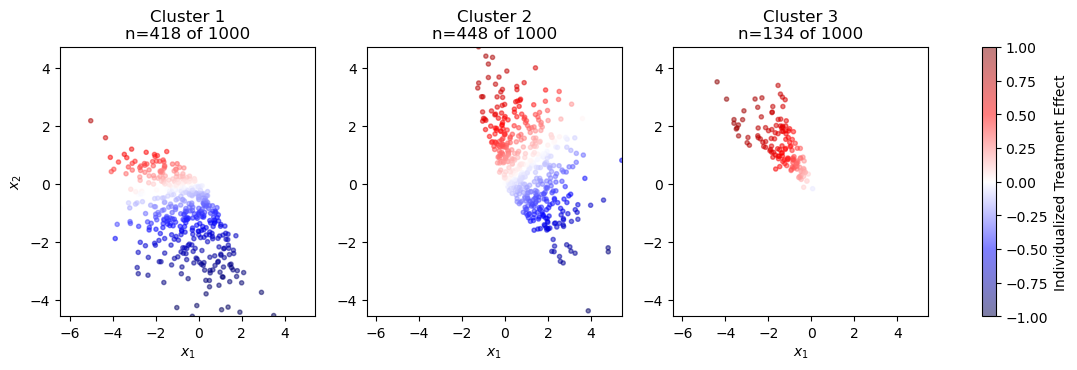

In [70]:
plot_clusters(X, y, cluster_real_cat)

In [71]:
# Here's our final gating network
gating_net.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 3)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [72]:
# And here are its weights and biases
gating_net.layers[0].get_weights()

[array([[-0.4801968 , -0.2751566 ,  0.63982123],
        [-0.5832096 , -0.5496915 ,  0.25315976]], dtype=float32),
 array([ 0.00735834,  0.01782322, -0.02518157], dtype=float32)]

## Putting it together

In [73]:
class ClusterIte():
    def __init__(self, K=3, experts=None, gating_net=None, Callback=None):
        self.K = K
        
        if experts is not None:
            self.experts = {f"ex_mod_{k}": experts for k in range(K)}
        else:
            self.experts = {f"ex_mod_{k}": LinearRegression() for k in range(K)}
        
        if gating_net is not None:
            self.gating_net = gating_net(K)
            if Callback is not None:
                self.Callback = Callback
            else:
                self.Callback = EarlyStopping(monitor='loss', patience=4)
        else:        
            self.gating_net = tf_model(K)
            self.Callback = EarlyStopping(monitor='loss', patience=4)
           
    def fit(self, X, y, maxit=100, epsi=1e-6, verbose=False, silence=False):
        X = X.copy()
        y = y.copy()
                
        # Initialize the cluster probabilities
        self.G = np.ones((len(X), self.K)) / self.K

        # Initialize the individual predictions from the experts
        self.U = np.random.normal(loc=0, scale=10, size=(len(X), self.K))

        # Broadcast our targets in a matrix for ease of use later
        Y = np.repeat(np.array(y)[:, np.newaxis], self.K, axis=1)
        # Iterate over the EM algorithm
        for it in range(maxit):
            
            ### E step ###
            # Compute individual contributions to each expert’s likelihood as
            L = stats.norm.pdf(Y, loc=self.U, scale=1)
            
            # Compute the posterior cluster probabilities as
            H = (self.G * L) / np.sum(self.G * L, axis=1)[:, np.newaxis]

            ### M step ###
            ## 1. Experts substeps
            # Fit all expert models separately
            for k, mod in enumerate(self.experts.values()):
                mod.fit(X, y, sample_weight=H[:, k])

            # Update the predictions from the expert networks as
            self.U = []
            for k, mod in enumerate(self.experts.values()):
                self.U.append(mod.predict(X))
            self.U = np.array(self.U).T
        
            ## 2. Gating network substep
            # Fit the gating network jointly
            self.gating_net.fit(X, H, epochs=50, batch_size=len(X), verbose=0, callbacks=[self.Callback])
            
            # Update the cluster probabilities as
            G_old = self.G
            self.G = self.gating_net.predict(X, verbose=0)
            
             # If verbose, print iterations and accuracies of the gating network
            if verbose and it % 10 == 0:
                print(f'Iteration {it+1} \
                    accuracy on H {(np.argmax(self.G, axis=1) == np.argmax(H, axis=1)).mean()*100:.2f}% \n', \
                    end='\r')
                
            # Check for convergence on the frobenius norm of the difference
            if np.linalg.norm(self.G - G_old, ord='fro') / (len(X) * self.K) < epsi: 
                if silence is False:
                    print(f'Converged at iteration {it+1} with accuracy on H {(np.argmax(self.G, axis=1) == np.argmax(H, axis=1)).mean()*100:.2f}%')
                break
            
            if it == maxit - 1 and silence is False:
                print(f'Reached max no. of iterations = {it+1}')
               
    def predict(self, X, verbose=False):
        pred_Gs = self.gating_net.predict(X, verbose=verbose)
        pred_Us = []
        for k, mod in enumerate(self.experts.values()):
            pred_Us.append(mod.predict(X))
        pred_Us = np.array(pred_Us).T
        
        return np.sum(pred_Gs * pred_Us, axis=1)

Test with default arguments

In [74]:
test_class_naive = ClusterIte()

In [75]:
test_class_naive.fit(X, y, maxit=100, epsi=1e-6, verbose=True)

Iteration 1                     accuracy on H 35.20% 
Converged at iteration 2 with accuracy on H 99.90%


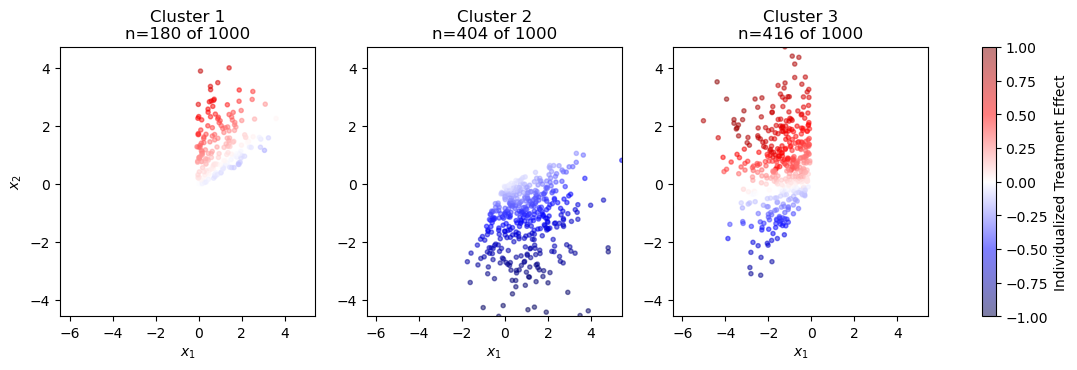

In [76]:
plot_clusters(X, y, np.argmax(test_class_naive.G, axis=1))

Make predictions of cluster probabilities for new Xs (future patients)

In [77]:
test_class_naive.gating_net.predict(np.array([[2,3]]))

1/1 [==============================] - 0s 112ms/step


array([[0.60699034, 0.19306657, 0.19994305]], dtype=float32)

Interestingly, we can apply our model to predict refined ITEs for new Xs (future patients). 

It's as through we had done a posteriori self supervised learning for the ITE function since we used only basline patient information and never their outcomes here!

In [78]:
test_class_naive.predict(np.array([[2,3]]))

array([0.51601842])

In [79]:
test_class_naive.gating_net.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 3)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


With the `ClusterIte` class we can easly change our experts and gating network to use Random Forrest and Deep Learning as follows

In [80]:
rf_experts = RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10)

In [81]:
# Instantiate our gating network
def custom_tf_model(n_clusters):
    model = Sequential()
    
    ## Below, you can put any sort of layer you like ... ##
    model.add(Dense(300, use_bias=True, activation='relu'))
    
    ## ... so long the network finishes with a dense layer  
    ## with softmax activation and n_clusters units
    model.add(Dense(n_clusters, use_bias=True, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

gating_net = custom_tf_model(K)

# You can pass in any sort of callback you like
Callback = EarlyStopping(monitor='loss', patience=4)

In [82]:
# Let's try with 5 clusters
test_class_custom = ClusterIte(K=5, experts=rf_experts, gating_net=custom_tf_model, Callback=Callback)

In [83]:
test_class_custom.fit(X, y, maxit=100, epsi=1e-6, verbose=True)

Iteration 1                     accuracy on H 19.50% 
Converged at iteration 2 with accuracy on H 100.00%


In [84]:
test_class_custom.gating_net.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 300)               900       
                                                                 
 dense_25 (Dense)            (None, 5)                 1505      
                                                                 
Total params: 2,405
Trainable params: 2,405
Non-trainable params: 0
_________________________________________________________________


## Finding the optimal no. of clusters via crossvalidation

In [85]:
from sklearn.model_selection import KFold
from tqdm import tqdm

In [86]:
class ClusterIte_cv:
    def __init__(self, nb_folds=3, **kwargs):
        self.nb_folds = nb_folds
        self.hyperparams = kwargs
        
    def fit(self, X, y, cluster_range=range(2,4), **kwargs):
        X = X.copy()
        y = y.copy()
        
        kf = KFold(n_splits = self.nb_folds)
        res = {}
        for k in tqdm(cluster_range):
            model = ClusterIte(K=k, **self.hyperparams)

            MSEs = []
            # Iterate over the folds
            for train_index, val_index in kf.split(X):
                # Split the data into training and validation sets
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                
                # Train your custom model on the training data
                model.fit(X_train, y_train, silence=True, **kwargs)
                
                # Evaluate your model on the validation data
                y_preds = model.predict(X_val, verbose=False)
                cv_mse = ((y_preds - y_val)**2).mean()
                MSEs.append(cv_mse)
            res[f'K={k}'] = MSEs
        self.cv_mse = pd.DataFrame(res)
        
    def best_K_tab_fun(self):
        res = pd.DataFrame({'MSE':self.cv_mse.mean(axis=0), 'se_MSE': self.cv_mse.std(axis=0) / np.sqrt(self.nb_folds)})
        res =res.reset_index().rename(columns={'index': 'K'})
        res['K'] = res['K'].str.extract('(\d+)').astype(int)
        return res.sort_values(by='MSE')
    
    def best_K_fun(self):
        pd_best_K = self.best_K_tab_fun()
        best_K = pd_best_K.iloc[0,0]
        best_K_mse = pd_best_K['MSE'].iloc[0]
        best_K_se = pd_best_K['se_MSE'].iloc[0]
        ub = best_K_mse + best_K_se
        best_K_within_se  = pd_best_K[pd_best_K['MSE'] <= ub].sort_values(by='K').iloc[0,0]
        self.best_K = best_K; self.best_K_within_se = best_K_within_se
        return best_K, best_K_within_se
    
    def plot(self):
        df = self.best_K_tab_fun().sort_values(by='K')
        plt.figure(figsize=(6, 6))
        plt.plot(df['K'], df['MSE'], color='blue')
        plt.fill_between(df['K'], df['MSE']-df['se_MSE'], df['MSE']+df['se_MSE'], color='lightblue')
        plt.xticks(df['K'])
        plt.xlabel('Number of clusters')
        plt.ylabel('MSE')
        plt.title('Crossvalidated MSE ± se')
        self.best_K_fun()
        best_K_tab = self.best_K_tab_fun()
        plt.scatter(self.best_K_within_se, best_K_tab[best_K_tab['K'] == self.best_K_within_se]['MSE'], marker='^', color='g', label='Optima within 1SE')
        plt.scatter(self.best_K, best_K_tab[best_K_tab['K'] == self.best_K]['MSE'], marker='v', color='b', label='Apparent Optima')
        plt.legend()
        plt.show()

With the `ClusterIte_cv` class we can easly perform crossvalidation to find the optimal no. of clusters
- We can still change our experts and gating network like so

In [87]:
base_learners = {'experts': RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10),
               'gating_net': custom_tf_model, 'Callback': Callback}

test_class = ClusterIte_cv(nb_folds=5, **base_learners)

- Or using the default (parametric) models

In [88]:
test_class = ClusterIte_cv(nb_folds=10)

- Run the crossvalidation in one line of code

In [89]:
test_class.fit(X,y, cluster_range = range(2,16), maxit=10, epsi=1e-6, verbose=False)

100%|██████████| 14/14 [01:37<00:00,  6.97s/it]


In [90]:
test_class.best_K_tab_fun()

,K,MSE,se_MSE
11,13,0.007685,0.000542
3,5,0.007991,0.000639
12,14,0.008109,0.000563
6,8,0.008215,0.000581
13,15,0.008275,0.000566
8,10,0.008530,0.000575
10,12,0.008542,0.000575
5,7,0.008664,0.000613
4,6,0.008779,0.000602
1,3,0.008902,0.000716


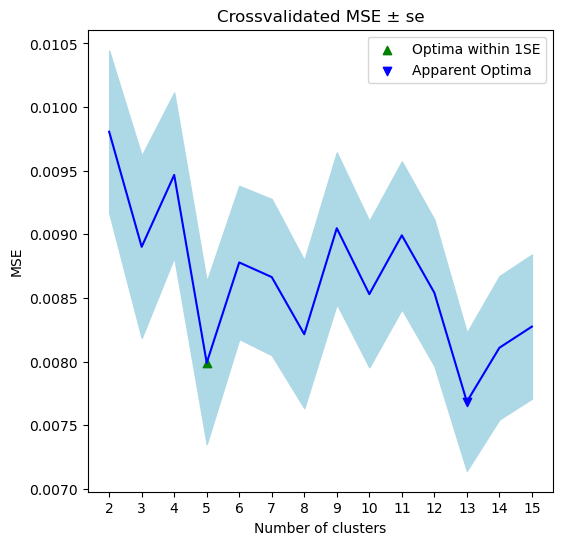

In [91]:
test_class.plot()

In [92]:
test_class.best_K_fun()

(13, 5)

## What remains to be done

- Parrallelization. Of which loop? all? (Good news is the algorithm appears relatively fast already)
- Implementation on real data
- Release a small library